# Classifying Images with a NN and DNN Model

## Introduction

In this notebook, you learn how to build a neural network to classify the tf-flowers dataset using a Deep Neural Network Model.

## Learning Objectives

* Define Helper Functions.
* Train and evaluate a Neural Network (NN) model.
* Train and evaluate a Deep Neural Network model.


Each learning objective will correspond to a __#TODO__ in the student lab notebook.


In [1]:
# Import and print the installed version of TensorFlow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
print(tf.version.VERSION)


2.11.0


In [2]:
conda install graphviz

Channels:
 - conda-forge
Platform: linux-64
Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


## Defining Helper Functions
#### Reading and Preprocessing image data

In [3]:
# Helper functions
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

# Call model.predict() on a few images in the evaluation dataset
def plot_predictions(filename):
  f, ax = plt.subplots(3, 5, figsize=(25,15))
  dataset = (tf.data.TextLineDataset(filename).
      map(decode_csv))
  for idx, (img, label) in enumerate(dataset.take(15)):
    ax[idx//5, idx%5].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    label = CLASS_NAMES[label.numpy()]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//5, idx%5].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))

def show_trained_weights(model):
  # CLASS_NAMES is ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
  LAYER = 1 # Layer 0 flattens the image, layer=1 is the first dense layer
  WEIGHT_TYPE = 0 # 0 for weight, 1 for bias

  f, ax = plt.subplots(1, 5, figsize=(15,15))
  for flower in range(len(CLASS_NAMES)):
    weights = model.layers[LAYER].get_weights()[WEIGHT_TYPE][:, flower]
    min_wt = tf.math.reduce_min(weights).numpy()
    max_wt = tf.math.reduce_max(weights).numpy()
    flower_name = CLASS_NAMES[flower]
    print("Scaling weights for {} in {} to {}".format(
        flower_name, min_wt, max_wt))
    weights = (weights - min_wt)/(max_wt - min_wt)
    ax[flower].imshow(weights.reshape(IMG_HEIGHT, IMG_WIDTH, 3));
    ax[flower].set_title(flower_name);

In [4]:
# The import statement combines two operations; it searches for the named module, then it binds the results of that search
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

def read_and_decode(filename, reshape_dims):
  # Read the file
  img = tf.io.read_file(filename)
  # Convert the compressed string to a 3D uint8 tensor.
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to the desired size.
  return tf.image.resize(img, reshape_dims)

CLASS_NAMES = [item.numpy().decode("utf-8") for item in 
               tf.strings.regex_replace(
                 tf.io.gfile.glob("gs://cloud-training-demos/practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/*"),
                 "gs://cloud-training-demos/practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/", "")]
CLASS_NAMES = [item for item in CLASS_NAMES if item.find(".") == -1]
print("These are the available classes:", CLASS_NAMES)

# the label is the index into CLASS_NAMES array
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label

These are the available classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Train and evaluate a Neural Network (NN) model

One way to get a more complex method is to interpose one or more Dense layers in between the input and output. The model now has three layers. A layer with trainable weights such as the one recently added, that is neither the input nor the output, is called a hidden layer.

In Keras, you introduce the activation function with tf.keras.activations.

The Rectified Linear Unit (ReLU) is the most commonly used activation function for hidden layers – other commonly used activation functions include sigmoid, tanh, and elu.

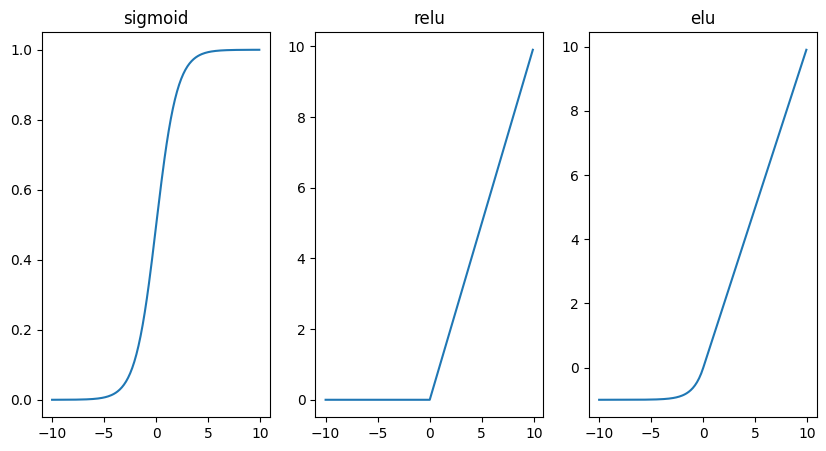

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt

fig, ax = plt.subplots(1, 3, figsize=(10,5))
x = np.arange(-10.0, 10.0, 0.1)
y = tf.keras.activations.sigmoid(x)
ax[0].plot(x, y);
ax[0].set_title("sigmoid")
y = tf.keras.activations.relu(x)
ax[1].plot(x, y);
ax[1].set_title("relu")
y = tf.keras.activations.elu(x)
ax[2].plot(x, y);
ax[2].set_title("elu");

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 128)               19267712  
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 19,268,357
Trainable params: 19,268,357
Non-trainable params: 0
_________________________________________________________________


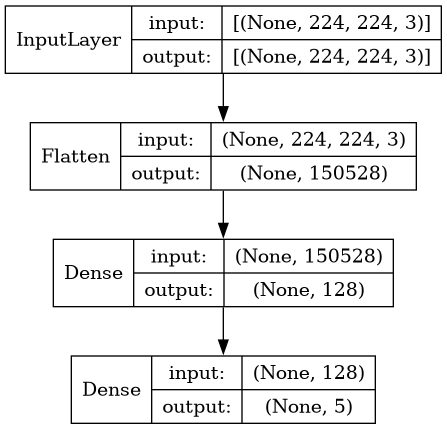

In [6]:
model = tf.keras.Sequential([
   tf.keras.layers.Flatten(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
   tf.keras.layers.Dense(128, activation='relu'),
   tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

In [7]:
model = tf.keras.Sequential([
   tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
   tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_2 (Dense)             (None, 5)                 752645    
                                                                 
Total params: 752,645
Trainable params: 752,645
Non-trainable params: 0
_________________________________________________________________


In [8]:
BATCH_SIZE = 32

train_dataset = (tf.data.TextLineDataset(
    "gs://cloud-training-demos/practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/train_set.csv").
    map(decode_csv)).batch(BATCH_SIZE)

eval_dataset = (tf.data.TextLineDataset(
    "gs://cloud-training-demos/practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/eval_set.csv").
    map(decode_csv)).batch(BATCH_SIZE)

# NN with one hidden layer
model = tf.keras.Sequential([
          tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
          tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
          tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)


Epoch 1/10
104/104 [==============================] - 62s 594ms/step - loss: 9.5614 - accuracy: 0.3070 - val_loss: 2.3087 - val_accuracy: 0.3324
Epoch 2/10
104/104 [==============================] - 60s 574ms/step - loss: 1.7011 - accuracy: 0.2355 - val_loss: 1.5877 - val_accuracy: 0.1973
Epoch 3/10
104/104 [==============================] - 54s 522ms/step - loss: 1.5969 - accuracy: 0.2633 - val_loss: 1.6062 - val_accuracy: 0.2378
Epoch 4/10
104/104 [==============================] - 57s 544ms/step - loss: 1.5902 - accuracy: 0.2658 - val_loss: 1.5841 - val_accuracy: 0.2541
Epoch 5/10
104/104 [==============================] - 56s 533ms/step - loss: 1.5936 - accuracy: 0.2594 - val_loss: 1.5982 - val_accuracy: 0.2432
Epoch 6/10
104/104 [==============================] - 55s 531ms/step - loss: 1.5885 - accuracy: 0.2600 - val_loss: 1.5995 - val_accuracy: 0.2432
Epoch 7/10
104/104 [==============================] - 55s 528ms/step - loss: 1.5935 - accuracy: 0.2548 - val_loss: 1.6052 - val_ac

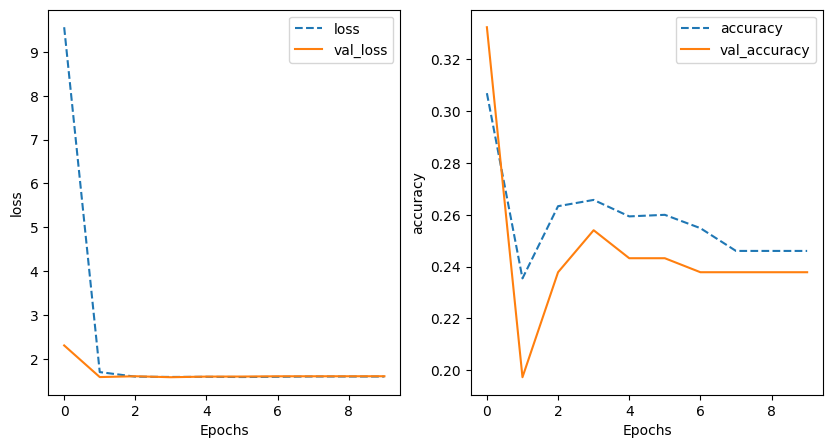

In [9]:
training_plot(['loss', 'accuracy'], history)

## Training the neural network

Training the neural network is similar to training the linear model. Compile the model passing in the optimizer, the loss, and the metrics. Then, call model.fit() passing in the datasets.

In [10]:
# parameterize to the values in the previous cell
def train_and_evaluate(batch_size = 32,
                       lrate = 0.001, # default in Adam constructor
                       l1 = 0,
                       l2 = 0,
                       num_hidden = 128):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  train_dataset = (tf.data.TextLineDataset(
      "gs://cloud-training-demos/practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/train_set.csv").
      map(decode_csv)).batch(batch_size)

  eval_dataset = (tf.data.TextLineDataset(
      "gs://cloud-training-demos/practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/eval_set.csv").
      map(decode_csv)).batch(32) # this doesn't matter

  # NN with one hidden layers
  model = tf.keras.Sequential([
              tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
              tf.keras.layers.Dense(num_hidden,
                                    kernel_regularizer=regularizer, 
                                    activation=tf.keras.activations.relu),
              tf.keras.layers.Dense(len(CLASS_NAMES), 
                                    kernel_regularizer=regularizer,
                                    activation='softmax')
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
  training_plot(['loss', 'accuracy'], history)
  return model

First, train your model by using 128 hidden layers.

Epoch 1/10
104/104 [==============================] - 57s 540ms/step - loss: 2.3572 - accuracy: 0.3515 - val_loss: 1.3678 - val_accuracy: 0.4189
Epoch 2/10
104/104 [==============================] - 67s 642ms/step - loss: 1.4270 - accuracy: 0.4036 - val_loss: 1.3843 - val_accuracy: 0.4297
Epoch 3/10
104/104 [==============================] - 56s 538ms/step - loss: 1.2931 - accuracy: 0.4682 - val_loss: 1.3058 - val_accuracy: 0.4432
Epoch 4/10
104/104 [==============================] - 57s 549ms/step - loss: 1.2495 - accuracy: 0.4752 - val_loss: 1.3244 - val_accuracy: 0.4676
Epoch 5/10
104/104 [==============================] - 56s 540ms/step - loss: 1.1922 - accuracy: 0.5000 - val_loss: 1.2948 - val_accuracy: 0.4892
Epoch 6/10
104/104 [==============================] - 56s 541ms/step - loss: 1.1678 - accuracy: 0.5130 - val_loss: 1.2947 - val_accuracy: 0.4919
Epoch 7/10
104/104 [==============================] - 56s 539ms/step - loss: 1.1444 - accuracy: 0.5306 - val_loss: 1.3441 - val_ac

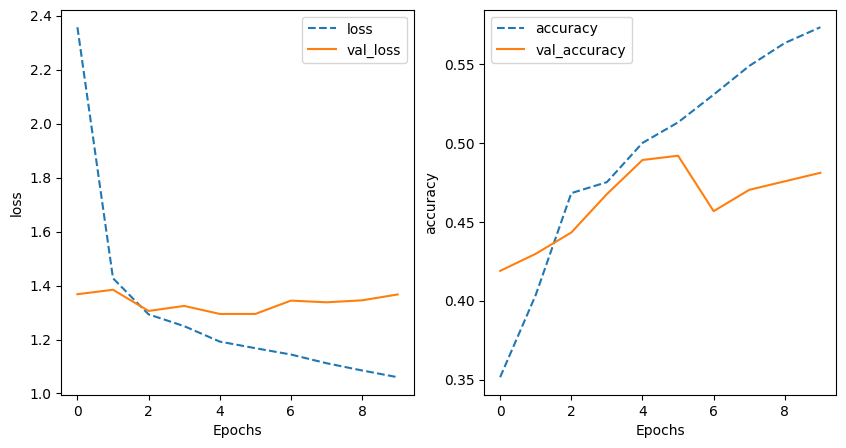

In [11]:
model = train_and_evaluate(batch_size=32, lrate=0.0001, l1=0, l2=0, num_hidden=128)

You would normally expect that adding layers to a model will improve the ability of the model to fit the training data, and thus lower the loss. Notice that it is not always the case though.

Epoch 1/10
104/104 [==============================] - 60s 569ms/step - loss: 2.6117 - accuracy: 0.3488 - val_loss: 1.8666 - val_accuracy: 0.3216
Epoch 2/10
104/104 [==============================] - 60s 571ms/step - loss: 1.5476 - accuracy: 0.4270 - val_loss: 1.4137 - val_accuracy: 0.4081
Epoch 3/10
104/104 [==============================] - 70s 671ms/step - loss: 1.4163 - accuracy: 0.4730 - val_loss: 1.3306 - val_accuracy: 0.4324
Epoch 4/10
104/104 [==============================] - 60s 573ms/step - loss: 1.3169 - accuracy: 0.5042 - val_loss: 1.3159 - val_accuracy: 0.4622
Epoch 5/10
104/104 [==============================] - 60s 572ms/step - loss: 1.2213 - accuracy: 0.5461 - val_loss: 1.4007 - val_accuracy: 0.4595
Epoch 6/10
104/104 [==============================] - 60s 572ms/step - loss: 1.1610 - accuracy: 0.5661 - val_loss: 1.4166 - val_accuracy: 0.4514
Epoch 7/10
104/104 [==============================] - 59s 566ms/step - loss: 1.0796 - accuracy: 0.5997 - val_loss: 1.3768 - val_ac

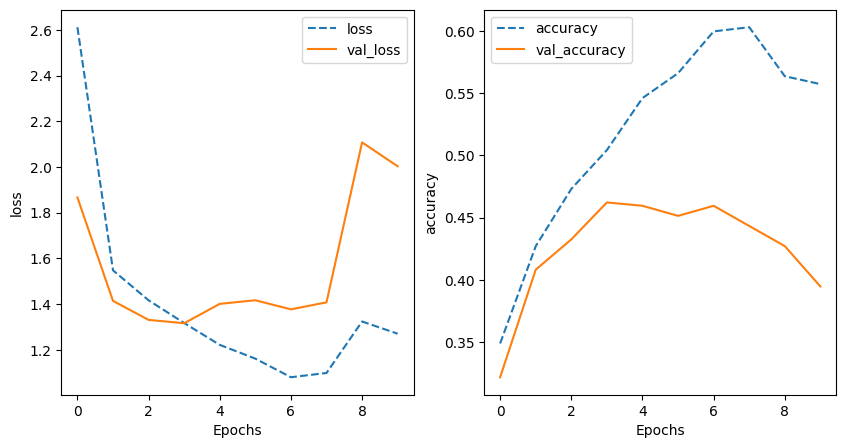

In [12]:
model = train_and_evaluate(batch_size=32, lrate=0.0001, l1=0, l2=0, num_hidden=256)

## Train and evaluate a Deep Neural Network model

Now train a DNN. You need to parameterize the number of layers, and the number of nodes in each layer.

In [13]:
# parameterize to the values in the previous cell
def train_and_evaluate(batch_size = 32,
                       lrate = 0.0001,
                       l1 = 0,
                       l2 = 0.001,
                       num_hidden = [64, 16]):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  train_dataset = (tf.data.TextLineDataset(
      "gs://cloud-training-demos/practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/train_set.csv").
      map(decode_csv)).batch(batch_size)

  eval_dataset = (tf.data.TextLineDataset(
      "gs://cloud-training-demos/practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/eval_set.csv").
      map(decode_csv)).batch(32) # this doesn't matter

  # NN with multiple hidden layers
  layers = [tf.keras.layers.Flatten(
      input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
      name='input_pixels')]
  layers = layers + [
      tf.keras.layers.Dense(nodes,
                            kernel_regularizer=regularizer, 
                            activation=tf.keras.activations.relu,
                            name='hidden_dense_{}'.format(hno))
          for hno, nodes in enumerate(num_hidden)
  ]
  layers = layers + [
      tf.keras.layers.Dense(len(CLASS_NAMES), 
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='flower_prob')
  ]

  model = tf.keras.Sequential(layers, name='flower_classification')
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False),
                metrics=['accuracy'])
  print(model.summary())
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
  training_plot(['loss', 'accuracy'], history)
  return model

Model: "flower_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_pixels (Flatten)      (None, 150528)            0         
                                                                 
 hidden_dense_0 (Dense)      (None, 64)                9633856   
                                                                 
 hidden_dense_1 (Dense)      (None, 16)                1040      
                                                                 
 flower_prob (Dense)         (None, 5)                 85        
                                                                 
Total params: 9,634,981
Trainable params: 9,634,981
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
104/104 [==============================] - 56s 531ms/step - loss: 1.7786 - accuracy: 0.2697 - val_loss: 1.7553 - val_accuracy: 0.2432
Epoch 2/10
104/10

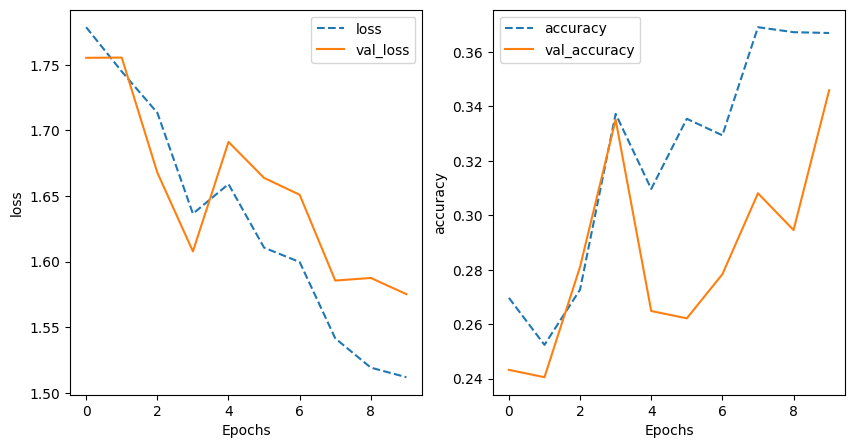

In [14]:
model = train_and_evaluate(lrate=0.0001, l2=0.001, num_hidden = [64, 16])


Displaying model predictions on the evaluation set...
1/1 [==============================] - 0s 18ms/step


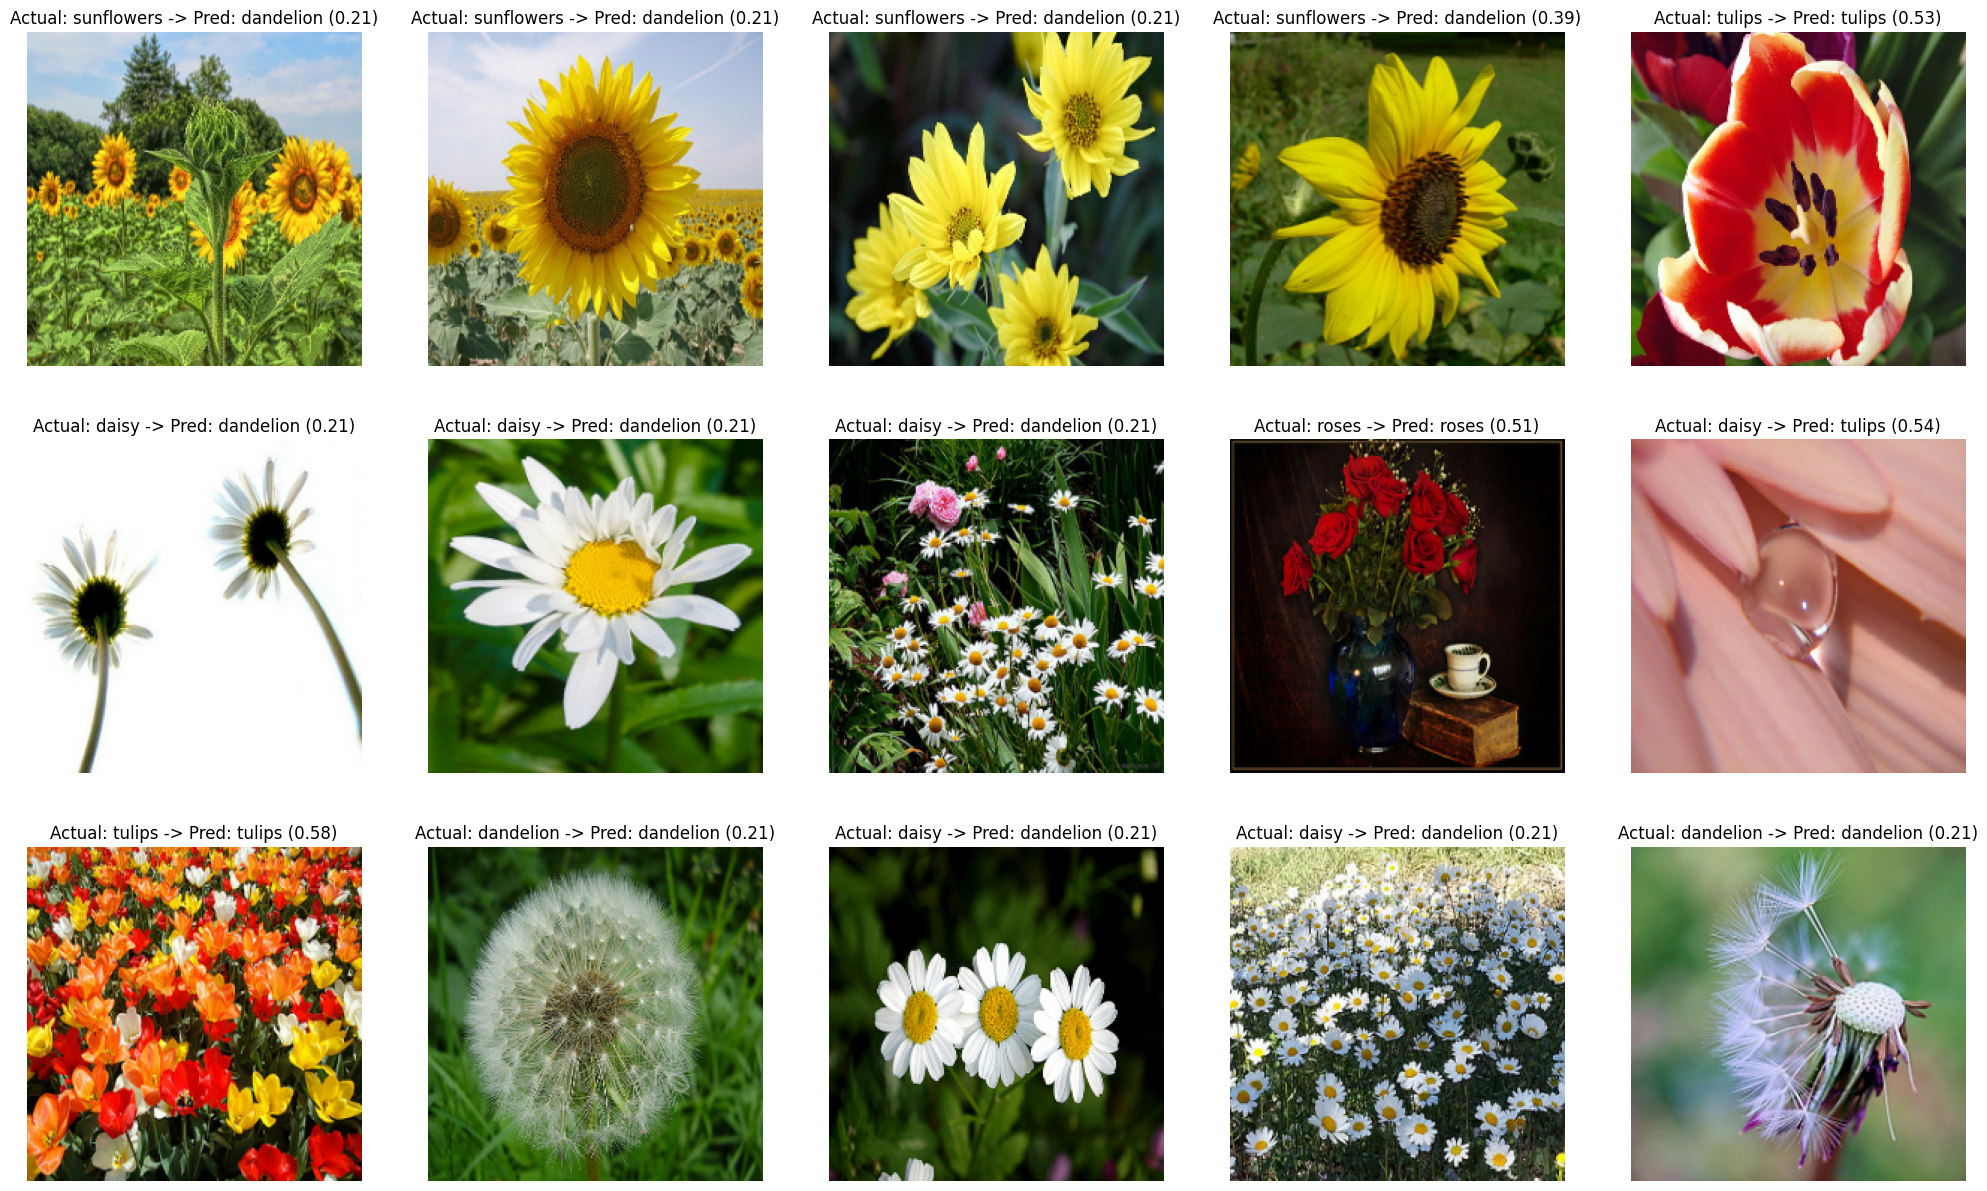


Displaying learned weights of the first dense layer...


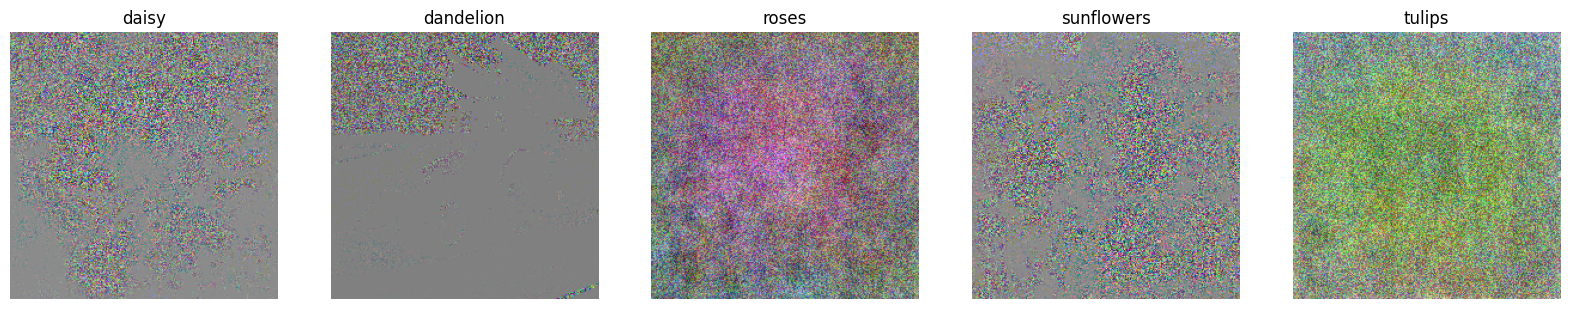

In [15]:
def plot_predictions(model, filename="gs://cloud-training-demos/practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/eval_set.csv"):
  f, ax = plt.subplots(3, 5, figsize=(25,15))
  dataset = (tf.data.TextLineDataset(filename).map(decode_csv))
  for idx, (img, label) in enumerate(dataset.take(15)):
    ax[idx//5, idx%5].imshow((img.numpy()))
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    label_text = CLASS_NAMES[label.numpy()]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//5, idx%5].set_title('Actual: {} -> Pred: {} ({:.2f})'.format(label_text, pred_label, prob))
    ax[idx//5, idx%5].axis('off')

def show_trained_weights(model):
  first_dense_layer = None
  for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Dense):
      first_dense_layer = layer
      break
  
  if first_dense_layer:
    weights, bias = first_dense_layer.get_weights()
    num_classes = len(CLASS_NAMES)
    
    if weights.shape[1] >= num_classes:
      f, ax = plt.subplots(1, num_classes, figsize=(20, 5))
      for flower in range(num_classes):
        flower_weights = weights[:, flower]
        
        img_weights = flower_weights.reshape(IMG_HEIGHT, IMG_WIDTH, 3)
        min_wt = tf.math.reduce_min(img_weights).numpy()
        max_wt = tf.math.reduce_max(img_weights).numpy()
        img_weights = (img_weights - min_wt) / (max_wt - min_wt)
        
        ax[flower].imshow(img_weights)
        ax[flower].set_title(CLASS_NAMES[flower])
        ax[flower].axis('off')
    else:
      print("First dense layer does not have enough neurons to visualize one per class.")
  else:
    print("No dense layer found in the model to visualize weights.")


print("\nDisplaying model predictions on the evaluation set...")
plot_predictions(model)
plt.show()

print("\nDisplaying learned weights of the first dense layer...")
show_trained_weights(model)
plt.show()

model.save('flower_classfication_model')

Congrats! You've completed the lab!